In [1]:
'''
#Train a simple deep CNN on the CIFAR10 small images dataset.
It gets to 75% validation accuracy in 25 epochs, and 79% after 50 epochs.
(it's still underfitting at that point, though).
'''

from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

batch_size = 32
num_classes = 10
epochs = 100
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'



Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
# The data, split between train and test sets:
x_train = np.load('data/x_train.npy')
y_train = np.load('data/y_train.npy')
x_test = np.load('data/x_test.npy')
y_test = np.load('data/y_test.npy')

# (x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train.shape, y_train.shape, x_test.shape, y_test.shape

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10))

In [4]:
# np.save('data/x_train.npy', x_train)
# np.save('data/y_train.npy', y_train)
# np.save('data/x_test.npy', x_test)
# np.save('data/y_test.npy', y_test)

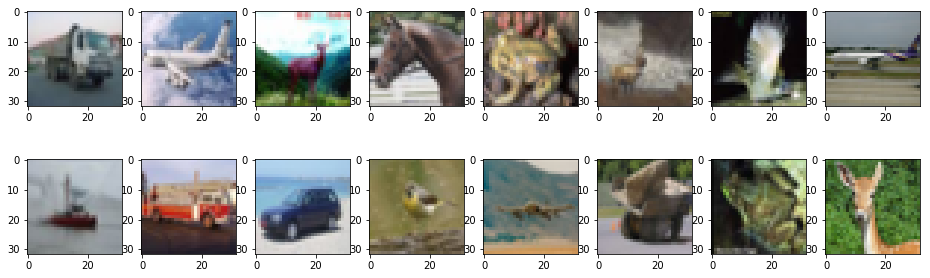

In [9]:
idx = np.random.permutation(x_train.shape[0])

fig, ax = plt.subplots(2,8,figsize=(16,5))
axes = ax.flatten()
for i in range(16):
    axes[i].imshow(x_train[idx[i]])

In [3]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))#, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))#, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))#, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# model.add(Conv2D(256, (3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
optimizer = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
# optimizer = keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

In [4]:
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

    early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.001, 
                           patience=8, 
                           mode='min', 
                           verbose=1)

    checkpoint = ModelCheckpoint('cifar10_baseline.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             period=1)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=4, 
                              min_lr=1e-6) 
    # Fit the model on the batches generated by datagen.flow().
    
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        steps_per_epoch=1500,
                        validation_data=(x_test, y_test),
                        callbacks=[reduce_lr, checkpoint, early_stop],
                        workers=4)



Using real-time data augmentation.
Epoch 1/100
1500/1500 [==============================] - 24s 16ms/step - loss: 2.2576 - acc: 0.1370 - val_loss: 2.1037 - val_acc: 0.2212

Epoch 00001: val_loss improved from inf to 2.10366, saving model to cifar10_baseline.h5
Epoch 2/100
1500/1500 [==============================] - 21s 14ms/step - loss: 2.1005 - acc: 0.2240 - val_loss: 1.9922 - val_acc: 0.2738

Epoch 00002: val_loss improved from 2.10366 to 1.99217, saving model to cifar10_baseline.h5
Epoch 3/100
1500/1500 [==============================] - 21s 14ms/step - loss: 2.0222 - acc: 0.2531 - val_loss: 1.9108 - val_acc: 0.3051

Epoch 00003: val_loss improved from 1.99217 to 1.91085, saving model to cifar10_baseline.h5
Epoch 4/100
1500/1500 [==============================] - 23s 15ms/step - loss: 1.9604 - acc: 0.2763 - val_loss: 1.8404 - val_acc: 0.3287

Epoch 00004: val_loss improved from 1.91085 to 1.84039, saving model to cifar10_baseline.h5
Epoch 5/100
1500/1500 [==========================

1500/1500 [==============================] - 22s 15ms/step - loss: 1.2589 - acc: 0.5549 - val_loss: 1.1491 - val_acc: 0.5976

Epoch 00039: val_loss improved from 1.16574 to 1.14911, saving model to cifar10_baseline.h5
Epoch 40/100
1500/1500 [==============================] - 23s 15ms/step - loss: 1.2560 - acc: 0.5543 - val_loss: 1.1153 - val_acc: 0.6061

Epoch 00040: val_loss improved from 1.14911 to 1.11530, saving model to cifar10_baseline.h5
Epoch 41/100
1500/1500 [==============================] - 23s 15ms/step - loss: 1.2536 - acc: 0.5537 - val_loss: 1.0933 - val_acc: 0.6161

Epoch 00041: val_loss improved from 1.11530 to 1.09329, saving model to cifar10_baseline.h5
Epoch 42/100
1500/1500 [==============================] - 23s 15ms/step - loss: 1.2354 - acc: 0.5605 - val_loss: 1.1261 - val_acc: 0.5988

Epoch 00042: val_loss did not improve from 1.09329
Epoch 43/100
1500/1500 [==============================] - 22s 15ms/step - loss: 1.2317 - acc: 0.5655 - val_loss: 1.0893 - val_acc:

In [4]:
# x_train.shape[0]/batch_size

1562

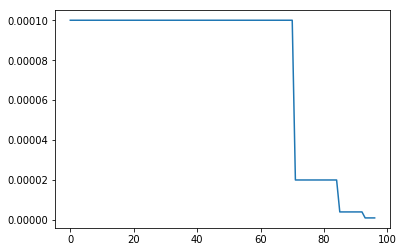

In [5]:
plt.plot(model.history.history['lr'])

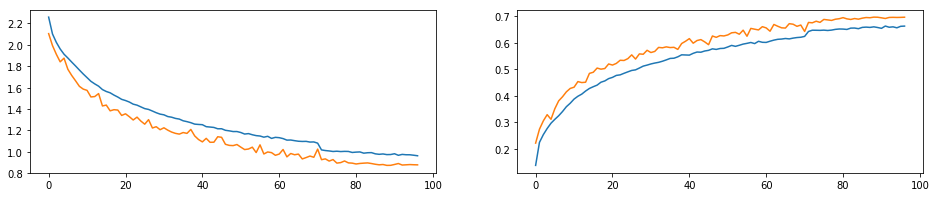

In [7]:
fig, ax = plt.subplots(1,2,figsize=(16,3))
ax[0].plot(range(97),model.history.history['loss'], range(97),model.history.history['val_loss'])
ax[1].plot(range(97),model.history.history['acc'],range(97),model.history.history['val_acc'])

In [8]:
# Save model and weights
# if not os.path.isdir(save_dir):
#     os.makedirs(save_dir)
# model_path = os.path.join(save_dir, model_name)
# model.save(model_path)
# print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 1s 82us/step
Test loss: 0.8787624685287475
Test accuracy: 0.697
